In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pwd

/content


In [ ]:
!cd "/content/gdrive/MyDrive/ETL1"

In [ ]:
#extraction of data
import struct
from PIL import Image
import numpy as np

def read_record_ETL1G(f):
    s = f.read(2052)
    r = struct.unpack('>H2sH6BI4H4B4x2016s4x', s)
    iF = Image.frombytes('F', (64, 63), r[18], 'bit', 4)
    iL = iF.convert('P')
    return r + (iL,)

def read_kana():
    katakana = np.zeros([51, 1411, 63, 64], dtype=np.uint8)
    for i in range(7,14):
        filename = '/content/gdrive/MyDrive/ETL1/ETL1C_{:02d}'.format(i)
        with open(filename, 'rb') as f: 
            if i!=13: limit = 8
            else: limit=3
            for dataset in range(limit):
                for j in range(1411):
                    try :
                        r = read_record_ETL1G(f)
                        katakana[(i - 7) * 8 + dataset, j] = np.array(r[-1])
                    except struct.error: # two imgs are blank according to the ETL website, so this prevents any errors
                        pass
    np.savez_compressed("kana.npz", katakana)

read_kana()

In [ ]:
#resizing of image and splitting images/labels to train and test
import skimage.transform
import numpy as np
from sklearn.model_selection import train_test_split

kana = np.load("kana.npz")['arr_0'].reshape([-1, 63, 64]).astype(np.float32)

kana = kana/np.max(kana) 

train_images = np.zeros([51 * 1411, 48, 48], dtype=np.float32)

for i in range(51 * 1411): 
    train_images[i] = skimage.transform.resize(kana[i], (48, 48))

arr = np.arange(51) 
train_labels = np.repeat(arr, 1411)


train_images, test_images, train_labels, test_labels = train_test_split(train_images, train_labels, test_size=0.2)

np.savez_compressed("katakana_train_images.npz", train_images)
np.savez_compressed("katakana_train_labels.npz", train_labels)
np.savez_compressed("katakana_test_images.npz", test_images)
np.savez_compressed("katakana_test_labels.npz", test_labels)

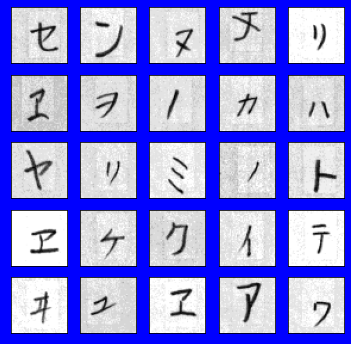

In [ ]:
#visualising extracted data
import matplotlib.pyplot as plt
plt.figure(figsize=(6,6)).patch.set_facecolor('blue')
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
plt.show()

NameError: name 'np' is not defined

<Figure size 720x720 with 0 Axes>

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K

train_images = np.load("katakana_train_images.npz")['arr_0']
train_labels = np.load("katakana_train_labels.npz")['arr_0']
test_images = np.load("katakana_test_images.npz")['arr_0']
test_labels = np.load("katakana_test_labels.npz")['arr_0']

if K.image_data_format() == "channels_first": 
  train_images = train_images.reshape(train_images.shape[0], 1,48,48)
  test_images = test_images.reshape(test_images.shape[0], 1,48,48)
  shape = (1,48,48)
else:
  train_images = train_images.reshape(train_images.shape[0], 48, 48, 1)
  test_images = test_images.reshape(test_images.shape[0], 48, 48, 1)
  shape = (48,48,1)



In [ ]:
datagen = ImageDataGenerator(rotation_range=15,zoom_range=0.2)
datagen.fit(train_images)
from keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D,Dropout,Flatten,Dense
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = shape))

model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))

model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(52, activation = "softmax"))


In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 48, 48, 32)        832       
                                                                 
 conv2d_8 (Conv2D)           (None, 48, 48, 32)        25632     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 24, 24, 32)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 24, 24, 32)        0         
                                                                 
 conv2d_9 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 conv2d_10 (Conv2D)          (None, 24, 24, 64)        36928     
                                                      

In [ ]:
model.compile(optimizer='adam', loss="sparse_categorical_crossentropy", metrics=['accuracy'])

model.fit_generator(datagen.flow(train_images,train_labels,shuffle=True),epochs=30,validation_data=(test_images,test_labels),callbacks = [keras.callbacks.EarlyStopping(patience=8,verbose=1,restore_best_weights=True),keras.callbacks.ReduceLROnPlateau(factor=0.5,patience=3,verbose=1)])

model.save("katakana-test-model.h5")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/30
1799/1799 [==============================] - 83s 30ms/step - loss: 1.2004 - accuracy: 0.6492 - val_loss: 0.2400 - val_accuracy: 0.9105 - lr: 0.0010
Epoch 2/30
1799/1799 [==============================] - 48s 27ms/step - loss: 0.4497 - accuracy: 0.8473 - val_loss: 0.1886 - val_accuracy: 0.9299 - lr: 0.0010
Epoch 3/30
1799/1799 [==============================] - 48s 27ms/step - loss: 0.3517 - accuracy: 0.8766 - val_loss: 0.1807 - val_accuracy: 0.9318 - lr: 0.0010
Epoch 4/30
1799/1799 [==============================] - 48s 27ms/step - loss: 0.3118 - accuracy: 0.8892 - val_loss: 0.1693 - val_accuracy: 0.9362 - lr: 0.0010
Epoch 5/30
1799/1799 [==============================] - 50s 28ms/step - loss: 0.2833 - accuracy: 0.8984 - val_loss: 0.1784 - val_accuracy: 0.9329 - lr: 0.0010
Epoch 6/30
1799/1799 [==============================] - 47s 26ms/step - loss: 0.2609 - accuracy: 0.9021 - val_loss: 0.1650 - val_accuracy: 0.9373 - lr: 0.0010
Epoch 7/30
1799/1799 [========================